# Determining Sigma 10 & R 10 of DESIJ0201-2739

Author: S M Rafee Adnan, Anowar Shajib

## Load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [2]:
data, header = fits.getdata("DESIJ0201-2739_F140W_drz_sci.fits", header=True)

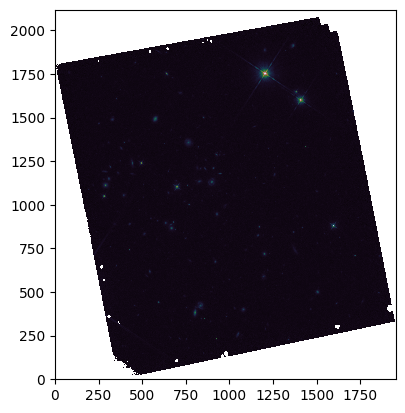

In [3]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [4]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12916/1236197877.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


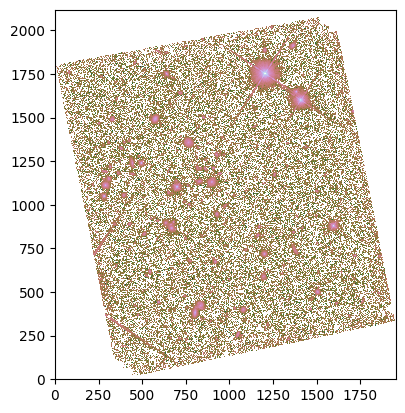

In [5]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [6]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.3398866643629581, 0.014041571279824873)

In [7]:
bkg_subtracted_data = data - bkg.background

In [8]:
threshold = 3 * bkg.background_rms

In [9]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [10]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [11]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2119, 1955)
nlabels: 692
labels: [  1   2   3   4   5 ... 688 689 690 691 692]


In [12]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 692
labels: [  1   2   3   4   5 ... 688 689 690 691 692]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

In [13]:
set_x_lim1, set_x_lim2 = 700, 1100
set_y_lim1, set_y_lim2 = 950, 1350

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12916/1540430693.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


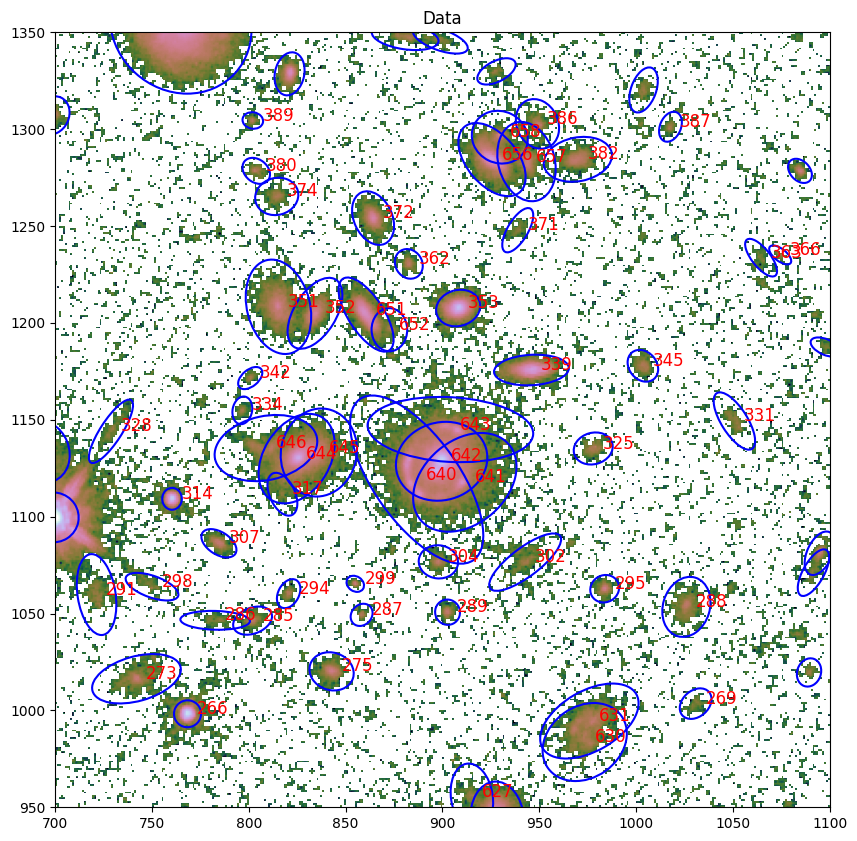

In [14]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

# Before determining the central ID
# for i in range(len(cat)):
#     ax1.text(
#         cat.xcentroid[i] + 5,
#         cat.ycentroid[i],
#         f"{i}",
#         c="r",
#         fontsize=12
#     )

# After determining the central ID
id_central = 642
for i in range(len(cat)):
    if np.abs(cat.xcentroid[i] - cat.xcentroid[id_central]) < 180 and np.abs(cat.ycentroid[i] - cat.ycentroid[id_central]) < 180:
      ax1.text(
          cat.xcentroid[i] + 5,
          cat.ycentroid[i],
          f"{i}",
          c="r",
          fontsize=12
      )

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12916/698855654.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


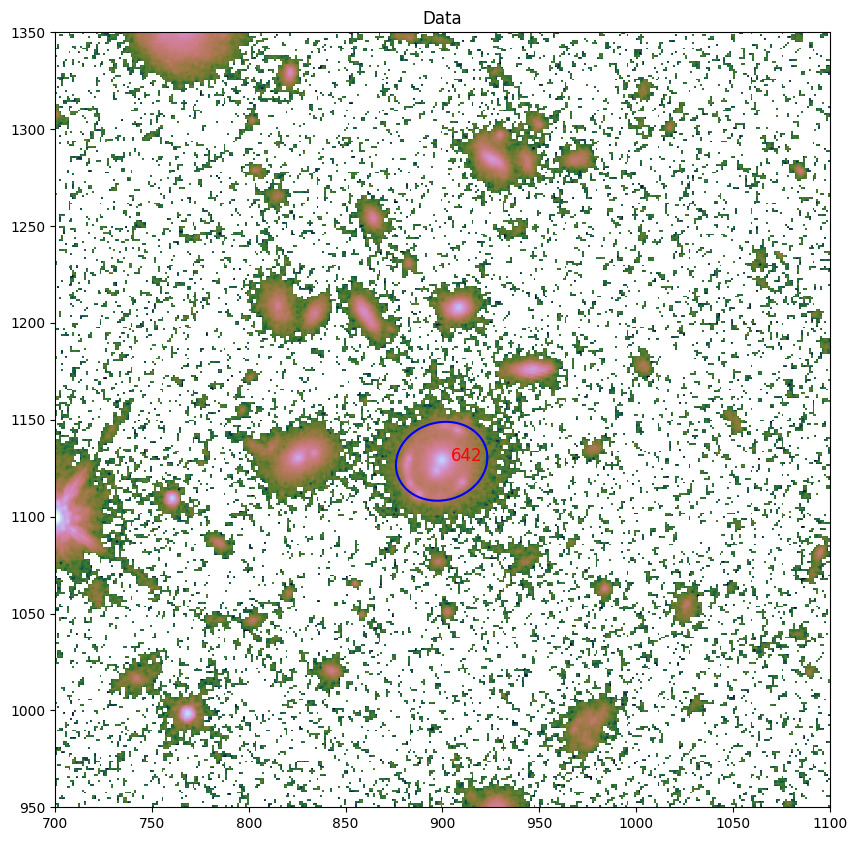

In [15]:
# object id of your central deflector/lens
id_central = 642

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [16]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [17]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:  #Find neighbouring galaxies within 20 arcseconds
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print("Number of all close galaxies within 20 arcsecond radius:", len(close_galaxies_all))

Number of all close galaxies within 20 arcsecond radius: 74


In [18]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print("Number of close galaxies excluding dim sources within 20 arcsecond radius:", len(close_galaxies_1))

Number of close galaxies excluding dim sources within 20 arcsecond radius: 51


In [19]:
def distance_arcsec(pixel_distance):
    
    """Convert distance from unit of pixels into arcsec unit.

    :param pixel_distance: distance in unit of pixels

    :return: distance in arcsec unit

    """
    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

In [20]:
# list of galaxies you want removed
remove_list = [642, #This is the central deflector
               640, # Object is part of the lensed arc
               643, # Object is part of the lensed arc
               641, # Object is part of the lensed arc
               317 # Halo of object ID 644
               ] 

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
304         51.945088          4.155607    6.190997    0.842566
645         63.513255          5.081060   63.836284    0.856614
339         66.083714          5.286697   89.389824    0.406777
302         67.596633          5.407731    8.122144    0.328467
652         73.053626          5.844290    4.870608    0.826112
644         74.834091          5.986727  145.469483    0.685292
299         77.383843          6.190707    1.951603    0.798570
289         77.960160          6.236813    4.346794    0.971244
325         78.524756          6.281981    6.153689    0.793196
353         79.543693          6.363495  116.108581    0.803053
651         85.162738          6.813019   69.392234    0.416069
287         89.381532          7.150523    1.894011    0.839001
646         90.926432          7.274115   25.049219    0.614385
352        100.525479          8.042038   30.959152    0.532004
362        103.274995          8.262000 

In [21]:
remove_list_1 = [642, #This is the central deflector
               640, # Object is part of the lensed arc
               643, # Object is part of the lensed arc
               641, # Object is part of the lensed arc
               ] 
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
304         51.945088          4.155607    6.190997    0.842566
645         63.513255          5.081060   63.836284    0.856614
339         66.083714          5.286697   89.389824    0.406777
302         67.596633          5.407731    8.122144    0.328467
652         73.053626          5.844290    4.870608    0.826112
644         74.834091          5.986727  145.469483    0.685292
289         77.960160          6.236813    4.346794    0.971244
325         78.524756          6.281981    6.153689    0.793196
353         79.543693          6.363495  116.108581    0.803053
651         85.162738          6.813019   69.392234    0.416069
646         90.926432          7.274115   25.049219    0.614385
352        100.525479          8.042038   30.959152    0.532004
362        103.274995          8.262000    4.504735    0.864468
295        106.811249          8.544900    6.681642    0.912629
345        114.973888          9.197911 

## Visualizing removed objects (except central deflector)

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12916/1299940480.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


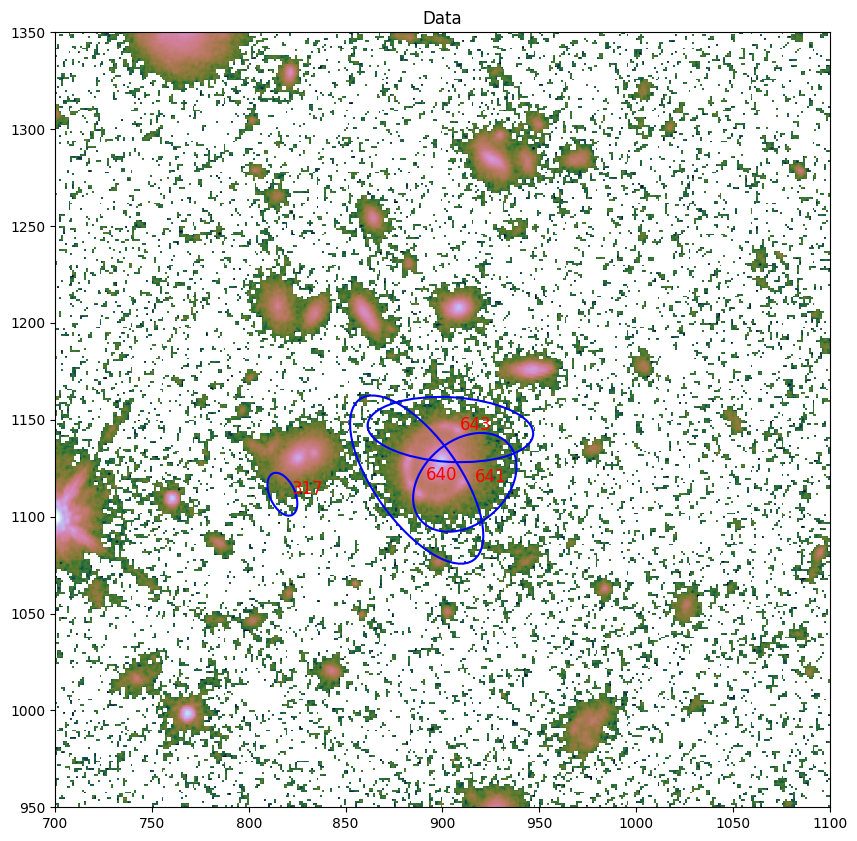

In [22]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

remove_list_exc_central = remove_list
if id_central in remove_list_exc_central:
    remove_list_exc_central.remove(id_central)

updated_remove_list = [s + 1 for s in remove_list_exc_central]
cat_subset_removed = cat.get_labels(updated_remove_list)
cat_subset_removed.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in remove_list:
    ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)



## Determining Sigma 10, 20 and R 10, 20

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12916/2882669529.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12916/2882669529.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12916/2882669529.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12916/2882669529.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


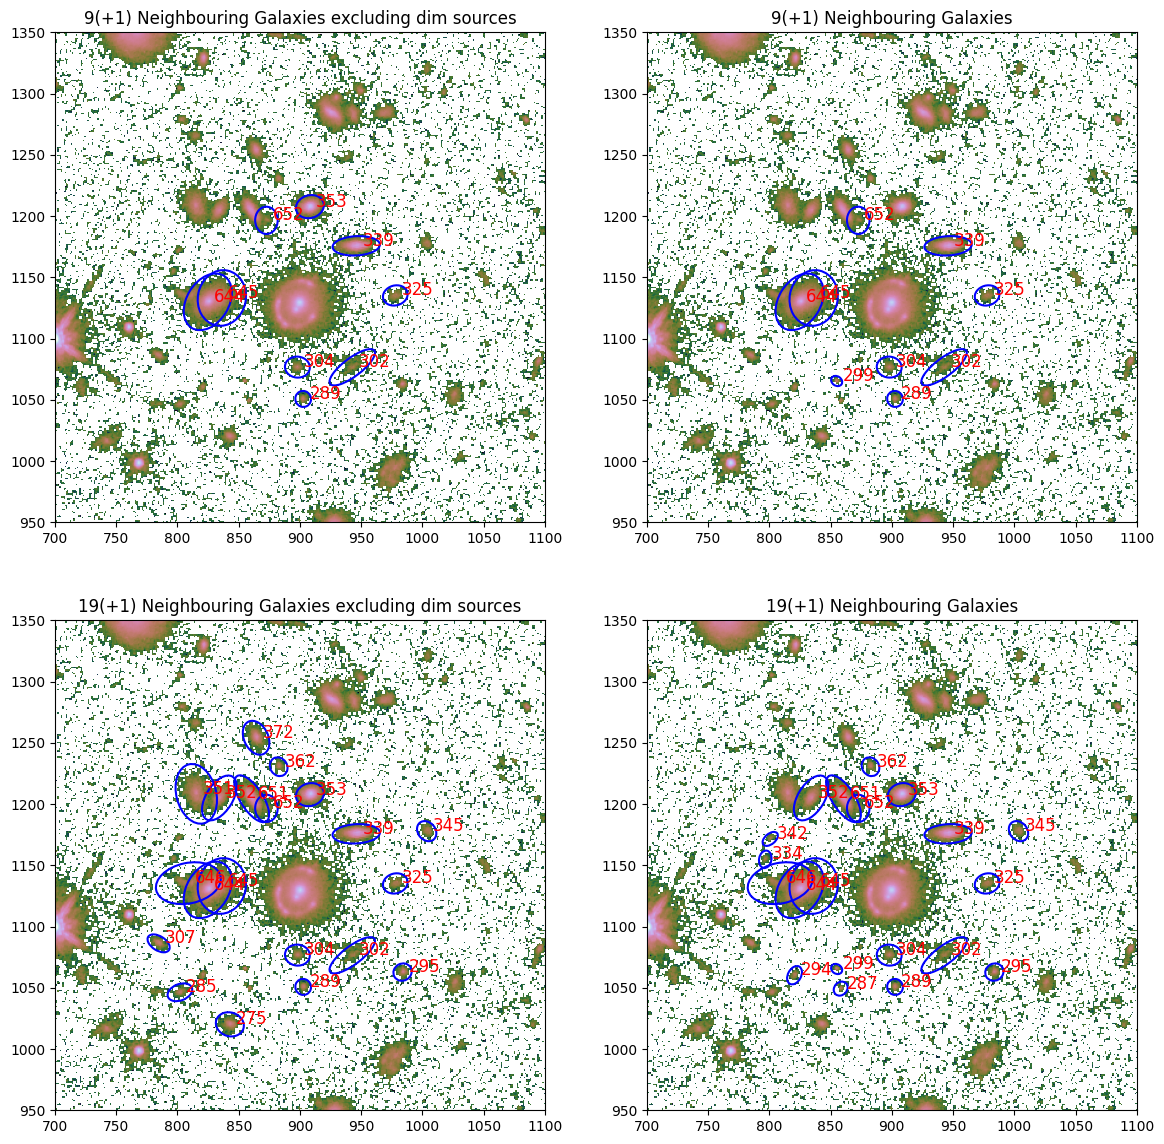

In [23]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10-1]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10-1]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10-1]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10-1]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("9(+1) Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("9(+1) Neighbouring Galaxies")
axs[1, 0].set_title("19(+1) Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("19(+1) Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

In [24]:
# One satellite galaxy (along 6 o'clock) near the lens galaxy was undetected due to
# threshold conditions. To include this object in the calculation, we only take
# the distance of the 9th and 19th closest galaxies to calculate R_10 and R_20,
# for both cases including and excluding dim sources.

R_10_1 = df_1_20.iloc[
    9 - 1, df_1_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
R_20_1 = df_1_20.iloc[
    19 - 1, df_1_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[
    9 - 1, df_all_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
R_20_all = df_all_20.iloc[
    19 - 1, df_all_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)


EXCLUDING DIM SOURCES
R 10: 6.363495409501858
R 20: 10.209190250923175
Sigma 10: 0.07860653574783298
Sigma 20: 0.0610797890968415

FOR All SOURCES
R 10: 6.28198050614131
R 20: 8.617052725699272
Sigma 10: 0.08065976614417354
Sigma 20: 0.08573588247302497


## Save the final deriverables to the YAML file

In [25]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ0201-2739_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20_flux_selected": Sigma_20_1,
    "Sigma_10": Sigma_10_all,
    "Sigma_20": Sigma_20_all,
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [26]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 0.5651197395242888, 'Sigma_10': 0.08065976614417354, 'Sigma_10_flux_selected': 0.07860653574783298, 'Sigma_20': 0.08573588247302497, 'Sigma_20_flux_selected': 0.0610797890968415, 'center_x_light': [0.05655224381829728, 0.0008430657528664398, 0.0009675553179374005], 'center_x_mass': [0.052281415631398764, 0.0058791466997811445, 0.004645715635573172], 'center_y_light': [0.13278941450356882, 0.0010464901760014744, 0.0008707858170620142], 'center_y_mass': [0.08004133398157273, 0.009221827913625205, 0.00802550570477975], 'gamma': [1.6238520208734553, 0.029971704308720204, 0.02535854092952694], 'gamma_shear': [0.07722340284064244, 0.0038374795032356385, 0.003304233893693845], 'phi_light': [-0.8363886678555648, 0.18034178658280542, 0.17325244089510883], 'phi_mass': [-0.01857297431305105, 0.08527861681341742, 0.08535104254339211], 'phi_shear': [-0.8490890794867727, 0.02027480910872126, 0.022663746045303856], 'q_light': [0.9701113290201959, 0.0068